# Unsupervised Learning: Time-Series K-Means with Dynamic Time Warping

## 1. Problem Statement

### Context:
Chronic absenteeism is a critical early indicator of disengagement and long-term academic risk. Understanding how absenteeism patterns evolve across schools over time can provide actionable insights for school administrators and policymakers to design targeted interventions.

### Why unsupervised learning and Dynamic Time Warping:
While overall levels of absenteeism are important, schools may follow different trajectories over time, especially since pandemic — some may improve, some worsen, and others fluctuate in unpredictable ways. Traditional monitoring often fails to capture these nuanced patterns.
Since I do not know beforehand which patterns exist, unsupervised learning — particularly time-series clustering — allows me to discover naturally occurring groups of schools based on their absenteeism trajectories.

Dynamic Time Warping (DTW) allows time-series clustering to focus on the shape of absenteeism trajectories, even when schools experience shifts at slightly different times. This makes DTW-based clustering especially appropriate for uncovering meaningful trajectory groups that reflect real-world variation in the timing of absenteeism changes across schools.

### Why this is important:
Identifying distinct absenteeism trajectory patterns can:
Help prioritize schools for intervention based on their long-term trends, not just current levels.
Uncover hidden at-risk groups that may not be visible in snapshot data.
Support early warning systems and resource allocation based on trajectory types.

### Key question
**What are distinct groups of schools that exhibit similar chronic absenteeism trajectories over multiple years using unsupervised time-series clustering?**

### Data
- **Data source:** Publicly available from the school district data portal.
- **Sample:** Approximately 150 schools (elementary, middle, and high schools, both traditional and non-traditional).
- **Outcome variable:** Chronic absenteeism rate (% of students chronically absent at each time point).
- **Definition of chronic absenteeism:** Students absent for more than 10% of enrolled school days at a given time point (e.g., more than 18 days absent in a 180-day school year).
- **Time coverage:** 17 time points from January 2020 (pre-pandemic) through April 2025.
- **Measurement frequency:** Three data collections per academic year (approximately October, January, and April), with slight variation in collection dates.

The objective is to identify distinct absenteeism trajectory groups using unsupervised time-series clustering. This approach enables discovery of naturally occurring patterns that may inform targeted monitoring and intervention strategies.



## 2. EDA Procedure

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [59]:
# Load data
file_path = 'attd_wide.xlsx'

# Read the Excel file
df = pd.read_excel(file_path)

# Quick preview of the data
df.head()

# Rename columns according to actual calendar dates
time_mapping = {
    'rateT0': '2020-01', 'rateT1': '2020-04', 'rateT2': '2020-10',
    'rateT3': '2021-01', 'rateT4': '2021-04', 'rateT5': '2021-10',
    'rateT6': '2022-01', 'rateT7': '2022-04', 'rateT8': '2022-10',
    'rateT9': '2023-01', 'rateT10': '2023-04', 'rateT11': '2023-10',
    'rateT12': '2024-01', 'rateT13': '2024-04', 'rateT14': '2024-10',
    'rateT15': '2025-01', 'rateT16': '2025-04'
}
df.rename(columns=time_mapping, inplace=True)

# Set SchoolID as index (optional)
df.set_index("SchoolID", inplace=True)

# Define time columns for modeling
time_cols = list(time_mapping.values())

# Quick check
df.head()

,2020-01,2020-04,2020-10,2021-01,2021-04,2021-10,2022-01,2022-04,2022-10,2023-01,2023-04,2023-10,2024-01,2024-04,2024-10,2025-01,2025-04
SchoolID,,,,,,,,,,,,,,,,,
100,15,16.0,23,23,30,35,31,32.917706,31,29,27,29,23,24,26,23,26
105,20,17.0,30,32,31,34,26,27.334852,33,32,30,28,28,28,21,25,28
110,32,31.0,35,44,54,52,46,50.569589,46,43,44,38,36,37,34,35,47
111,8,9.0,35,38,37,29,24,21.911765,31,26,23,26,27,27,26,22,25
114,78,86.0,5,5,5,71,89,91.666667,90,86,85,5,9,7,5,5,6


## 3. Exploratory Data Analysis (EDA)

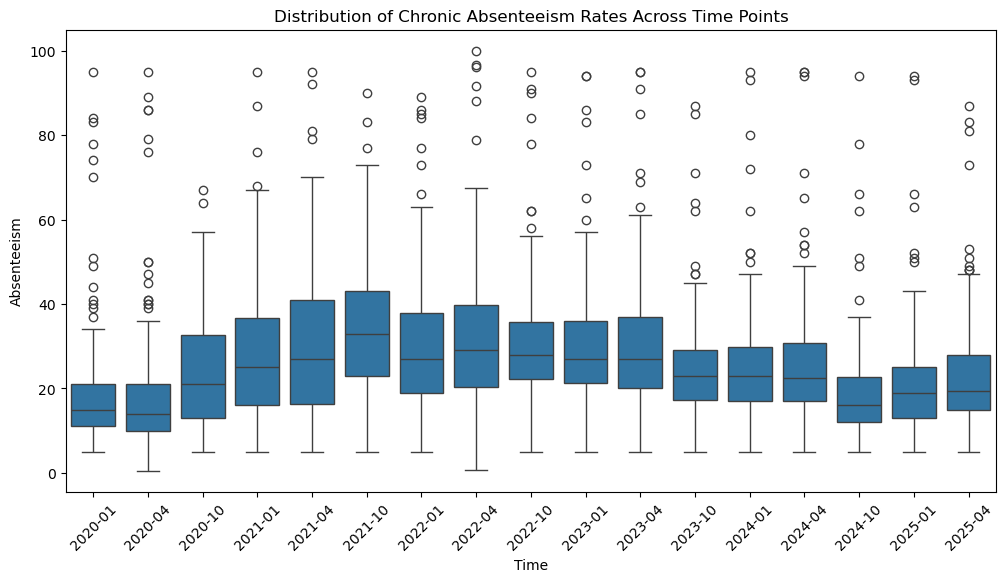

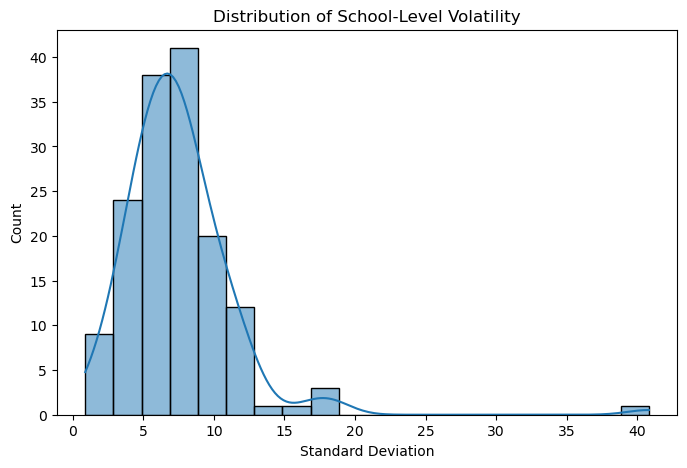

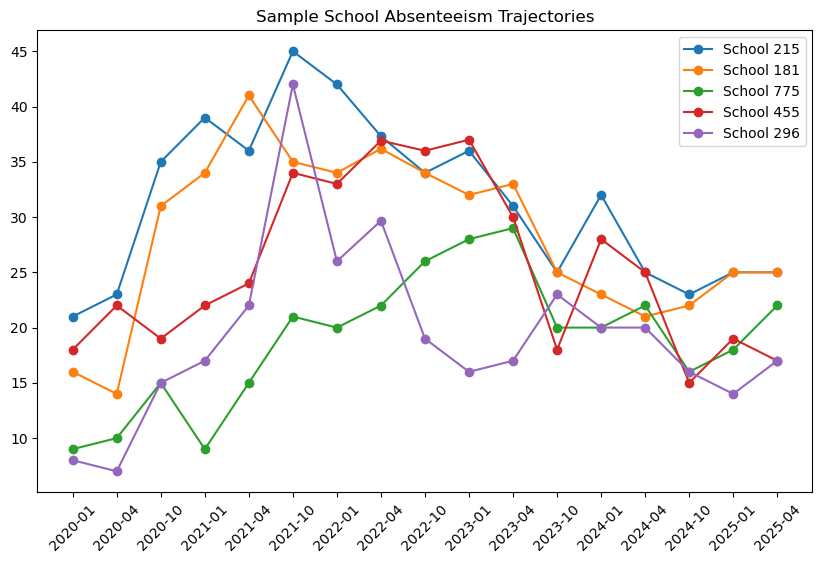

In [60]:
# Reset index to get SchoolID as column for melting
df_long = df.reset_index().melt(id_vars='SchoolID', var_name='Time', value_name='Absenteeism')

# Box Plot over time
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long, x='Time', y='Absenteeism')
plt.xticks(rotation=45)
plt.title("Distribution of Chronic Absenteeism Rates Across Time Points")
plt.show()

# School level Volatility 
df['Volatility'] = df[time_cols].std(axis=1)

plt.figure(figsize=(8, 5))
sns.histplot(df['Volatility'], bins=20, kde=True)
plt.title("Distribution of School-Level Volatility")
plt.xlabel("Standard Deviation")
plt.show()


# Random sample of school trajectories
sample_schools = random.sample(list(df.index), 5)

plt.figure(figsize=(10, 6))
for sid in sample_schools:
    school_data = df.loc[sid, time_cols].values.flatten()
    plt.plot(time_cols, school_data, marker='o', label=f"School {sid}")

plt.title("Sample School Absenteeism Trajectories")
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Description of Exploratory Data Analysis Results
### 1. Distribution of Absenteeism Rates Across Time Points

The distribution of chronic absenteeism rates shows substantial variability across schools at each time point. Absenteeism rates generally increased during the early pandemic period (2020-2021), peaked around 2021-2022, and gradually declined afterward, though considerable variation remains across schools even in later years. The presence of consistent high outliers across all time points suggests that some schools have persistently severe absenteeism challenges.

### 2. Distribution of School-Level Volatility

The distribution of school-level volatility, measured as the standard deviation of absenteeism rates over time, is right-skewed. Most schools show relatively low to moderate volatility (standard deviation between 5 and 10 percentage points), while a smaller subset of schools exhibit much higher variability in absenteeism patterns over time.

### 3. Random sample of School trajectories

The sample trajectories illustrate the diversity of absenteeism patterns observed across individual schools. While some schools exhibit consistently low rates with minor fluctuations, others demonstrate significant increases or decreases over time, with some showing sharp pandemic-related spikes followed by gradual recovery. This school-level variation underscores the heterogeneity that underlies the broader cluster patterns, highlighting the importance of longitudinal monitoring to identify both persistent challenges and emerging improvements at the school level.

## 4. Model Building & Training: 
## Time-Series Clustering (Time Series K-Means with Dynamic Time Warping)

In [61]:
pip install tslearn

Note: you may need to restart the kernel to use updated packages.


In [62]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

### Model Building and Training

In [63]:
# Extract only time series data
X = df[time_cols].values.astype(float)
X = X.reshape((X.shape[0], X.shape[1], 1))

### Model Evaluation: Elbow Method 

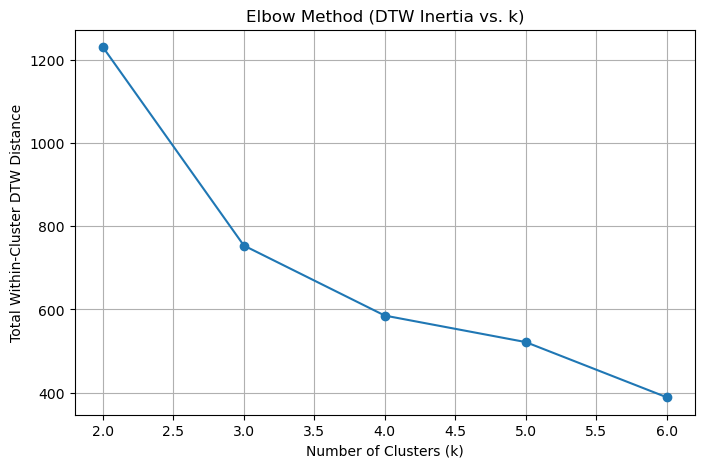

In [64]:
inertia = []
k_range = range(2, 7)

for k in k_range:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
    model.fit(X)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.title("Elbow Method (DTW Inertia vs. k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Total Within-Cluster DTW Distance")
plt.grid(True)
plt.show()

## Interpretation of Results from Elbow Methods

The elbow plot shows a steep reduction in total within-cluster DTW distance when increasing the number of clusters from 2 to 3, suggesting that moving to 3 clusters captures substantial additional structure in the data. Beyond k=3, the improvements in fit become relatively smaller, with diminishing returns for k=4 and higher. This pattern suggests that a 3-cluster solution offers a reasonable balance between model simplicity and capturing meaningful variation in absenteeism trajectories.

## Final Model Training

In [65]:
model_k3 = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=0)
labels_k3 = model_k3.fit_predict(X)

# Attach cluster labels back to dataframe
df['Cluster'] = labels_k3
df.head()

,2020-01,2020-04,2020-10,2021-01,2021-04,2021-10,2022-01,2022-04,2022-10,2023-01,2023-04,2023-10,2024-01,2024-04,2024-10,2025-01,2025-04,Volatility,Cluster
SchoolID,,,,,,,,,,,,,,,,,,,
100,15,16.0,23,23,30,35,31,32.917706,31,29,27,29,23,24,26,23,26,5.446549,0
105,20,17.0,30,32,31,34,26,27.334852,33,32,30,28,28,28,21,25,28,4.714039,0
110,32,31.0,35,44,54,52,46,50.569589,46,43,44,38,36,37,34,35,47,7.237949,0
111,8,9.0,35,38,37,29,24,21.911765,31,26,23,26,27,27,26,22,25,8.057443,0
114,78,86.0,5,5,5,71,89,91.666667,90,86,85,5,9,7,5,5,6,40.811399,1


## 5. Results

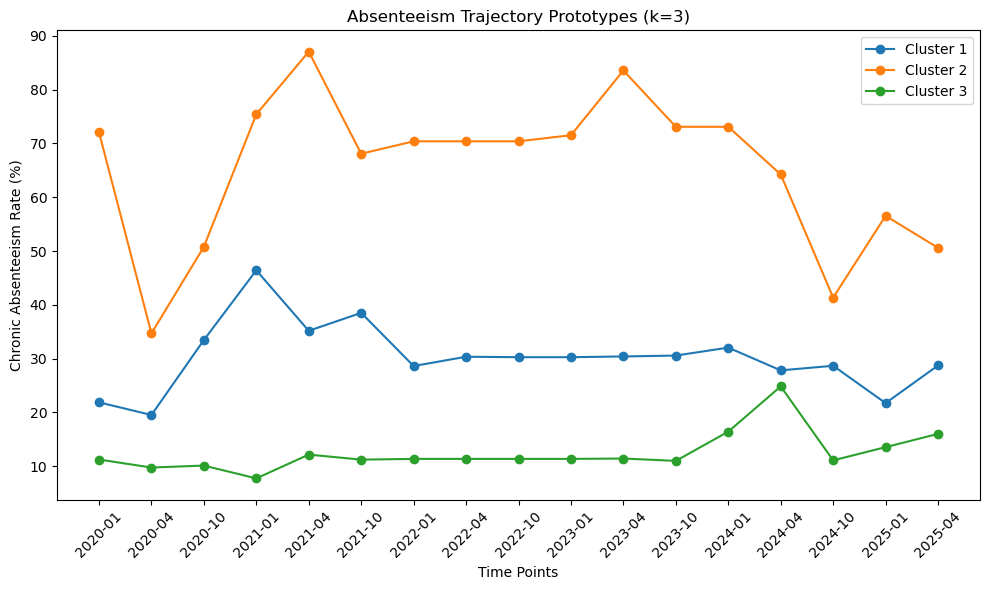

   Cluster  Number of Schools
0        1                 67
1        2                 10
2        3                 73


In [66]:
plt.figure(figsize=(10, 6))
for i, center in enumerate(model_k3.cluster_centers_):
    plt.plot(time_cols, center.ravel(), marker='o', label=f"Cluster {i+1}")

plt.title("Absenteeism Trajectory Prototypes (k=3)")
plt.xlabel("Time Points")
plt.ylabel("Chronic Absenteeism Rate (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Display distribution of schools across clusters
cluster_counts = df['Cluster'].value_counts().sort_index()

# Create a nice summary table
summary_table = pd.DataFrame({
    'Cluster': cluster_counts.index + 1,  # since your plot labels clusters as 1, 2, 3
    'Number of Schools': cluster_counts.values
})

print(summary_table)

The three cluster prototypes reveal distinct absenteeism patterns across schools. Cluster 3 (n=73) includes schools with consistently low absenteeism (around 10%) with slight increases in recent years. On the other hand, cluster 1 (n=67) includes schools with moderate absenteeism rates (around 30%) that remained relatively stable over time. Cluster 2 (n=10) captures schools with persistently high absenteeism (70-80%) for most of the period, but shows signs of gradual improvement beginning around 2024, suggesting emerging recovery among some of the highest-need schools. 

## 6. Discussion

#####
All in all, the time-series clustering analysis revealed meaningful variation in chronic absenteeism trajectories across schools 
over the multi-year period spanning before, during, and after the COVID-19 pandemic. The elbow method suggested that a three-cluster 
solution provided an optimal balance between model fit and parsimony, capturing the dominant patterns while avoiding over-fragmentation.

The time-series clustering identified three distinct chronic absenteeism trajectories across schools from 2020 to 2025. Cluster 3 includes schools with consistently low absenteeism (10%), Cluster 1 shows stable moderate absenteeism (30%), and Cluster 2 reflects persistently high absenteeism (70-80%) with some recent signs of improvement beginning in 2024. Approximately half of the schools fell into the low-absenteeism group, while the remainder were split between moderate and high-risk groups. 
**These patterns highlight the need for differentiated responses: while Cluster 2 schools may benefit from sustained support to continue recent gains, schools in Cluster 2 may require more targeted and intensive interventions to prevent further escalation.**

### 7. GitHub Repository Address for Details


### Full code and data available at: https://github.com/juck37/DSMP/tree/Unsupervised-Learning
see ML_attendance.ipynb